In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import models, layers, activations
from keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
x_data = np.load('face/face_x_data.npy') # x_save.npy
y_data = np.load('face/face_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [3]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
#X_train = X_train / 255
print("X_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

X_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [4]:
from tensorflow.keras.applications import Xception

class Xception_GRU(keras.Model):
    def __init__(self, num_classes):
        super(Xception_GRU, self).__init__()
        #self.BZ = input_shape[0]
        #self.frame = input_shape[1]
        self.xc = TimeDistributed(Xception(weights='imagenet', include_top=False,
                                               pooling='max'))
        self.xc.trainable = False
        self.bilstm = layers.Bidirectional(layers.GRU(128), merge_mode='concat')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense = layers.Dense(num_classes, activation='softmax')
        self.max_pool = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))
        self.dropout2 = layers.Dropout(0.2)
        self.dropout3 = layers.Dropout(0.3)
        self.flat = TimeDistributed(Flatten())

    def call(self, x):
        x = self.xc(x)
        x = self.flat(x)
        x = self.dropout2(x)
        x = self.bilstm(x)
        #x = self.dense2(x)
        x = self.dropout2(x)
        return self.dense(x)

In [5]:
model = Xception_GRU(num_classes = 11)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose = 1, validation_split=0.2, callbacks = [es])

Epoch 1/100
60/60 [==============================] - 1469s 24s/step - loss: 2.3730 - accuracy: 0.1016 - val_loss: 2.2751 - val_accuracy: 0.1437
Epoch 2/100
60/60 [==============================] - 1335s 22s/step - loss: 2.2087 - accuracy: 0.1958 - val_loss: 2.2792 - val_accuracy: 0.1562
Epoch 3/100
60/60 [==============================] - 1334s 22s/step - loss: 2.0966 - accuracy: 0.2505 - val_loss: 2.2245 - val_accuracy: 0.1625
Epoch 4/100
60/60 [==============================] - 1646s 27s/step - loss: 1.9497 - accuracy: 0.3417 - val_loss: 2.1567 - val_accuracy: 0.2417
Epoch 5/100
60/60 [==============================] - 1517s 25s/step - loss: 1.7888 - accuracy: 0.3885 - val_loss: 2.1066 - val_accuracy: 0.2542
Epoch 6/100
60/60 [==============================] - 1963s 33s/step - loss: 1.5776 - accuracy: 0.4646 - val_loss: 2.0804 - val_accuracy: 0.2562
Epoch 7/100
60/60 [==============================] - 2047s 34s/step - loss: 1.3614 - accuracy: 0.5620 - val_loss: 2.3773 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


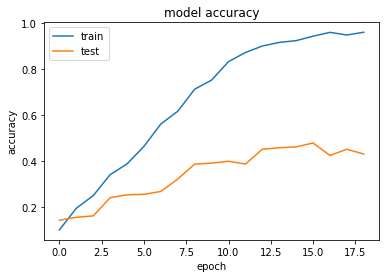

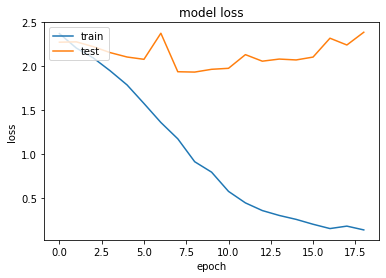

In [7]:

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
score = model.evaluate(X_test, Y_test, batch_size = 32, verbose = 1)
print(score[1] ,score[0]) 

19/19 [==============================] - 551s 29s/step - loss: 2.0619 - accuracy: 0.4883
0.4883333444595337 2.0619263648986816


In [9]:
 model.save_weights('xceptiom_bigru')